# Short pipeline

Contains only the main code necessary to run this project. No additional visualisations or performance improvements.

## 1. Imports

In [2]:
import os
import pandas as pd
import numpy as np
import random
import shutil
from shutil import copyfile
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras import Model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
import matplotlib.patches as mpatches
from sklearn.utils import shuffle
from tqdm import tqdm

2024-09-26 16:00:55.288191: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-26 16:00:55.293423: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-26 16:00:55.340121: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-26 16:00:55.385948: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-26 16:00:55.424047: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

In [3]:
base_dir  = "/home/maver02/Projects/Infrastructure_suite_project/Development/find-the-dog-project/CLOUD/data/image-segmentation-brain-tumor/"
os.chdir(base_dir)

## 2. Data Processing

In [4]:
df = pd.read_csv(os.path.join(base_dir + "Brain Tumor.csv"))[['Image', 'Class']]
display(df.head())
print(df.shape)

,Image,Class
0,Image1,0
1,Image2,0
2,Image3,1
3,Image4,1
4,Image5,0


(3762, 2)


In [5]:
# Split Training + Validation with Testing Set
def split_size(df, size):
    """
    Calculate the split size based on the given fraction of the DataFrame length.
    """
    return int(size * len(df))


train_labels = df['Class'].values[:split_size(df, 0.8)]
train_file_names = df['Image'].values[:split_size(df, 0.8)]

val_labels = df['Class'].values[split_size(df, 0.8):split_size(df, 0.9)]
val_file_names = df['Image'].values[split_size(df, 0.8):split_size(df, 0.9)]

test_labels = df['Class'].values[split_size(df, 0.9):]
test_file_names = df['Image'].values[split_size(df, 0.9):]

# labels are arrays of 1 or 0, names are arrays of image file names

In [6]:
# Split Training + Validation with Testing Set
def split_array_labels(arr_image, arr_label):
    """
    Split the array of images and labels into two separate arrays based on the label.
    """
    arr_image_0 = arr_image[np.where(arr_label==0)]
    arr_image_1 = arr_image[np.where(arr_label==1)]
    return {'0':arr_image_0, '1':arr_image_1}

train_arr_dict = split_array_labels(train_file_names, train_labels)
val_arr_dict = split_array_labels(val_file_names, val_labels)
test_arr_dict = split_array_labels(test_file_names, test_labels)

# each is a dictionary with keys '0' and '1', values are arrays of file names

In [7]:
# create directories for training, validation and testing
def create_empty_directories(base_dir):
    # in case you want to run it several times, delete the directory and create new one
    check_exist_path = os.path.join(base_dir, '_MODELLING')
    if os.path.isdir(check_exist_path):
        shutil.rmtree(check_exist_path)
        print("Remove old directories")
    
    for label in ['0','1']:
        training_dir = os.path.join(base_dir, '_MODELLING', 'training', label)
        validation_dir = os.path.join(base_dir, '_MODELLING', 'validation', label)
        testing_dir = os.path.join(base_dir, '_MODELLING', 'testing', label)    
        os.makedirs(training_dir)
        os.makedirs(validation_dir)
        os.makedirs(testing_dir)

    print(f"Created empty  training, validation and testing directories")

create_empty_directories(base_dir)

# copy data into the directories
def split_data(SOURCE_DIR, train_arr_dict, val_arr_dict, test_arr_dict):
    for label in tqdm(['0','1']):
        for file_name in train_arr_dict[label]:
            file_name = f"{file_name}.jpg"
            source = os.path.join(SOURCE_DIR, 'Brain Tumor', 'Brain Tumor', file_name)
            destination = os.path.join(base_dir, '_MODELLING', 'training', label, file_name)
            copyfile(source, destination)

        for file_name in val_arr_dict[label]:
            file_name = f"{file_name}.jpg"
            source = os.path.join(SOURCE_DIR, 'Brain Tumor', 'Brain Tumor', file_name)
            destination = os.path.join(base_dir, '_MODELLING', 'validation', label, file_name)
            copyfile(source, destination)
        
        for file_name in test_arr_dict[label]:
            file_name = f"{file_name}.jpg"
            source = os.path.join(SOURCE_DIR, 'Brain Tumor', 'Brain Tumor', file_name)
            destination = os.path.join(base_dir, '_MODELLING', 'testing', label, file_name)
            copyfile(source, destination)
    print(f"Created training, validation and testing directories containing images")
    
split_data(base_dir, train_arr_dict, val_arr_dict, test_arr_dict)

Remove old directories
Created empty  training, validation and testing directories


100%|██████████| 2/2 [00:00<00:00,  4.43it/s]

Created training, validation and testing directories containing images


Now the folders contain the data. Data augmentation, and training can be performed.

## 3. Modelling

In [8]:
import mlflow
mlflow.set_tracking_uri("http://localhost:5000")

# Create a new MLflow Experiment
mlflow.set_experiment("Training_Brain_Tumor")


<Experiment: artifact_location='mlflow-artifacts:/881152748453209801', creation_time=1727189773129, experiment_id='881152748453209801', last_update_time=1727189773129, lifecycle_stage='active', name='Training_Brain_Tumor', tags={}>

### 3.1. Model 1 without data augmentation

Create the generator. 

In [9]:
# Loads the data from the directories, preprocesses the images 
# and creates the generators

modelling_base_dir = os.path.join(base_dir, '_MODELLING')
os.chdir(modelling_base_dir)

def train_val_generators(TRAINING_DIR, VALIDATION_DIR, TEST_DIR):

    # Instantiate the ImageDataGenerator class without augmentation parameters
    train_datagen = ImageDataGenerator(rescale=1./127.5)

    # Pass in the appropriate arguments to the flow_from_directory method
    train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=32,
                                                      class_mode='binary',
                                                      target_size=(150, 150))

    # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
    valid_or_test_datagen = ImageDataGenerator(rescale=1./127.5)

    # Pass in the appropriate arguments to the flow_from_directory method
    validation_generator = valid_or_test_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=32,
                                                                class_mode='binary',
                                                                target_size=(150, 150))
    
    test_generator = valid_or_test_datagen.flow_from_directory(directory=TEST_DIR,
                                                                batch_size=32,
                                                                class_mode='binary',
                                                                target_size=(150, 150))
    return train_generator, validation_generator, test_generator

training_dir = os.path.join(modelling_base_dir, 'training')
validation_dir = os.path.join(modelling_base_dir, 'validation')
testing_dir = os.path.join(modelling_base_dir, 'testing')

train_generator, validation_generator, test_generator = train_val_generators(training_dir, validation_dir, testing_dir)

# train generator is a directory iterator, which yields batches of images that are preprocessed with the ImageDataGenerator


Found 3009 images belonging to 2 classes.
Found 376 images belonging to 2 classes.
Found 377 images belonging to 2 classes.


In [71]:

# Initiate base model
base_model = tf.keras.applications.MobileNetV2(input_shape=(150, 150, 3),
                                               include_top=False,
                                               weights='imagenet')
# Layers of the base model will not be updated during training.
base_model.trainable = False

# Output layer of the base model becomes inut to additinal custom layer
last_output = base_model.output

# takes output of the base model and adds additional layers on top of it
def transfer_learning(last_output, pre_trained_model):
    """
    Applies transfer learning to a pre-trained model by adding custom layers.
    Args:
        last_output (tf.Tensor): The output tensor from the last layer of the pre-trained model.
        pre_trained_model (tf.keras.Model): The pre-trained model to which new layers will be added.
    Returns:
        tf.keras.Model: A new model with the added custom layers on top of the pre-trained model.
    """
    # Flatten the output layer to 1 dimension
    x = tf.keras.layers.Flatten()(last_output)
    # Add a fully connected layer with 1024 hidden units and ReLU activation
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    # Add a dropout rate of 0.6
    x = tf.keras.layers.Dropout(0.6)(x)  
    # Add a final sigmoid layer for classification
    x = tf.keras.layers.Dense(1, activation='sigmoid')(x)          
    # Create the complete model by using the Model class
    model = Model(inputs=pre_trained_model.input, outputs=x)
    
    return model


# Train the model
from mlflow.models import infer_signature

with mlflow.start_run() as run:

    # Create the model
    model = transfer_learning(last_output, base_model)

    # stop training if the validation loss does not decrease for 3 consecutive epochs
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

    # set model configuration
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0003),
                loss = 'binary_crossentropy',
                metrics=['accuracy'])

    params = {'epochs': 5, 'batch_size': 32, 'lr': 0.0003}
    # now the model is ready to be trained


    # Train the model
    history = model.fit(train_generator,
                            validation_data=validation_generator,
                            epochs=1,
                            callbacks=[callback]) 
    
    # Infer the model signature
    signature = infer_signature(train_generator[0][0], model.predict(train_generator[0][0]))

    # Log parameters and metrics using the MLflow APIs
    mlflow.log_params(params)

    mlflow.tensorflow.log_model(
            model=model,
            artifact_path = "model",
            signature=signature,
            registered_model_name="Brain_Tumor_Model_v1"
    )

    

/tmp/ipykernel_9640/3331885118.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(input_shape=(150, 150, 3),


95/95 ━━━━━━━━━━━━━━━━━━━━ 27s 262ms/step - accuracy: 0.8346 - loss: 1.7706 - val_accuracy: 0.8963 - val_loss: 0.5004
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step


Registered model 'Brain_Tumor_Model_v1' already exists. Creating a new version of this model...
2024/09/26 18:00:50 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Brain_Tumor_Model_v1, version 4
Created version '4' of model 'Brain_Tumor_Model_v1'.
2024/09/26 18:00:50 INFO mlflow.tracking._tracking_service.client: 🏃 View run learned-hare-855 at: http://localhost:5000/#/experiments/881152748453209801/runs/22705df023f54984b5830eeedb81d432.
2024/09/26 18:00:50 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/881152748453209801.


Load image and deploy model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


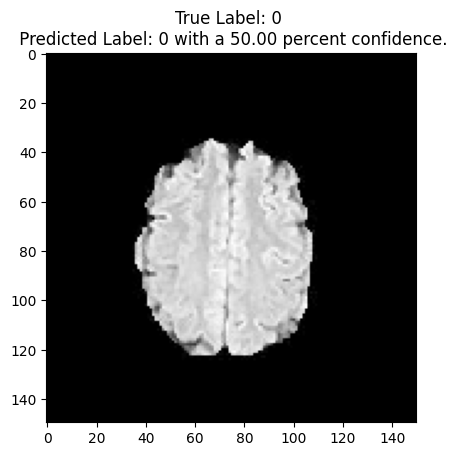

In [74]:
testing_base_dir = os.path.join(modelling_base_dir, 'testing')
# load random image from the testing set
random_image = random.choice(os.listdir(os.path.join(testing_base_dir, '0')))
y_true = '0'
img = image.load_img(os.path.join(testing_base_dir, '0', random_image), target_size=(150, 150))

x = image.img_to_array(img)

x /= 127.5
x = np.expand_dims(x, axis=0)
preprocess_images = np.vstack([x])

# predict the label of the image
classes = model.predict(preprocess_images)
score = tf.nn.sigmoid(classes[0])
if classes[0]>0.5:
    predicted_label = 1
else:
    predicted_label = 0
plt.title(f'True Label: {y_true} \n Predicted Label: {predicted_label} with a {100 * np.max(score):.2f} percent confidence.')
plt.imshow(img)
plt.show()

In [75]:
import mlflow.pyfunc

model_name = "Brain_Tumor_Model_v1"
model_version = 3

model_for_inference = mlflow.pyfunc.load_model(model_uri=f"models:/{model_name}/{model_version}")

In [91]:
import mlflow
model_uri = f"models:/{model_name}/{model_version}"
print(mlflow.get_artifact_uri(model_uri))

mlflow-artifacts:/881152748453209801/bffa76578b2a404492a03e34e11341ec/artifacts/models:/Brain_Tumor_Model_v1/3


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


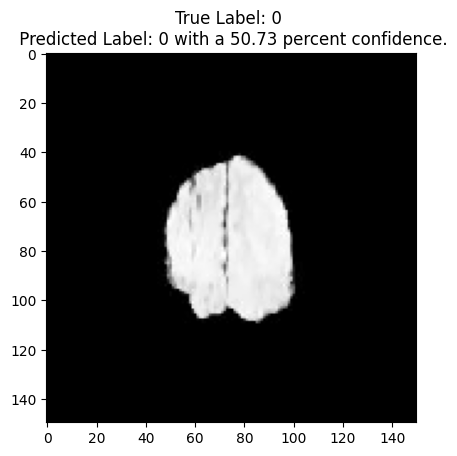

In [90]:
testing_base_dir = os.path.join(modelling_base_dir, 'testing')
true_label = '0'
# load random image from the testing set
random_image = random.choice(os.listdir(os.path.join(testing_base_dir, true_label)))
img = image.load_img(os.path.join(testing_base_dir, true_label, random_image), target_size=(150, 150))

x = image.img_to_array(img)

x /= 127.5
x = np.expand_dims(x, axis=0)
preprocess_images = np.vstack([x])

# predict the label of the image
classes = model_for_inference.predict(preprocess_images)
score = tf.nn.sigmoid(classes[0])
if classes[0]>0.5:
    predicted_label = 1
else:
    predicted_label = 0
plt.title(f'True Label: {true_label} \n Predicted Label: {predicted_label} with a {100 * np.max(score):.2f} percent confidence.')
plt.imshow(img)
plt.show()

### 3.2. Model 2 - Data augmentation

In [ ]:
# Loads the data from the directories, preprocesses the images 
# and creates the generators

modelling_base_dir = os.path.join(base_dir, '_MODELLING')
os.chdir(modelling_base_dir)

def train_val_generators(TRAINING_DIR, VALIDATION_DIR, TEST_DIR):

    # Instantiate the ImageDataGenerator class (don't forget to set the arguments to augment the images)
    train_datagen = ImageDataGenerator(rescale=1./127.5,
                                       rotation_range=30,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')

    # Pass in the appropriate arguments to the flow_from_directory method
    train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=32,
                                                      class_mode='binary',
                                                      target_size=(150, 150))

    # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
    valid_or_test_datagen = ImageDataGenerator(rescale=1./127.5)

    # Pass in the appropriate arguments to the flow_from_directory method
    validation_generator = valid_or_test_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=32,
                                                                class_mode='binary',
                                                                target_size=(150, 150))
    
    test_generator = valid_or_test_datagen.flow_from_directory(directory=TEST_DIR,
                                                                batch_size=32,
                                                                class_mode='binary',
                                                                target_size=(150, 150))
    return train_generator, validation_generator, test_generator

training_dir = os.path.join(modelling_base_dir, 'training')
validation_dir = os.path.join(modelling_base_dir, 'validation')
testing_dir = os.path.join(modelling_base_dir, 'testing')

train_generator, validation_generator, test_generator = train_val_generators(training_dir, validation_dir, testing_dir)

# train generator is a directory iterator, which yields batches of images that are preprocessed with the ImageDataGenerator

In [ ]:
# Initiate base model
base_model = tf.keras.applications.MobileNetV2(input_shape=(150, 150, 3),
                                               include_top=False,
                                               weights='imagenet')
# Layers of the base model will not be updated during training.
base_model.trainable = False

# Output layer of the base model becomes inut to additinal custom layer
last_output = base_model.output

# takes output of the base model and adds additional layers on top of it
def transfer_learning(last_output, pre_trained_model):
    """
    Applies transfer learning to a pre-trained model by adding custom layers.
    Args:
        last_output (tf.Tensor): The output tensor from the last layer of the pre-trained model.
        pre_trained_model (tf.keras.Model): The pre-trained model to which new layers will be added.
    Returns:
        tf.keras.Model: A new model with the added custom layers on top of the pre-trained model.
    """
    # Flatten the output layer to 1 dimension
    x = tf.keras.layers.Flatten()(last_output)
    # Add a fully connected layer with 1024 hidden units and ReLU activation
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    # Add a dropout rate of 0.6
    x = tf.keras.layers.Dropout(0.6)(x)  
    # Add a final sigmoid layer for classification
    x = tf.keras.layers.Dense(1, activation='sigmoid')(x)          
    # Create the complete model by using the Model class
    model = Model(inputs=pre_trained_model.input, outputs=x)
    
    return model

# Create the model
model = transfer_learning(last_output, base_model)

# stop training if the validation loss does not decrease for 3 consecutive epochs
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# set model configuration
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0003),
            loss = 'binary_crossentropy',
            metrics=['accuracy'])

In [ ]:
# Train model and log it in MLFlow
mlflow.tensorflow.autolog(checkpoint=True, checkpoint_save_best_only=False)

with mlflow.start_run() as run:
    history = model.fit(train_generator,
                        validation_data=validation_generator,
                        epochs=5,
                        callbacks=[callback])   